# Summary of BodyFat Analysis

# 1. Introduction

The body fat percentage of a human or other living being is the total mass of fat divided by total body mass, times 100; body fat includes essential body fat and storage body fat. Essential body fat is necessary to maintain life and reproductive functions. Epidemiologically, the percentage of body fat in an individual varies according to sex and age. The body fat percentage is a measure of fitness level, since it is the only body measurement which directly calculates a person's relative body composition without regard to height or weight.

However, accurate measurement of body fat is costly and it is desirable to use more convenient methods to estimate body fat. There are many methods to build predictive models, from linear regression to Lasso regression to more complicated ones like random forest. In this project, our group try to come up with a simple, robust and accurate method to estimate percentage of body fat using clinically available measurements. 

We come up with a result that a multiple linear model, with covariates *ABDOMEN*, *WRIST* and *WEIGHT* predicts *BODYFAT* very accurately, and stays simple and robust as well.

# 2. Data Preprocessing

The data *BodyFat* includes a response column, ***BODYFAT***, an index column, ***IDNO***, and 15 possible variables including *AGE*, *WEIGHT(lbs)*, *HEIGHT(inches)*, etc. The measurement units of each variable are shown in table below. 

|**BodyFat**|**Age**|**Weight**|**Height**|**Adiposity**|**Neck**|**Chest**|**Abdomen**|**Hip**|**Thigh**|**Knee**|**Ankle**|**Biceps**|**Foream**|**Wrist**|
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|%|years|lbs|inches|bmi|cm|cm|cm|cm|cm|cm|cm|cm|cm|cm|

 Notice here we do not consider ***DENSITY*** as a possible variable because *density* and *bodyfat* are perfectly related to each other by the formula $100*B = 495/D - 450$. Moreover, *density* is not a variable that is able to be measured directly, while **BodyFat** can be measured and therefore we can check if the prediction is accurate.

To begin with, we take a rough look at the column *BODYFAT*.

In [72]:
source("./code/data.R");summary(BodyFat$BODYFAT)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   12.80   19.00   18.94   24.60   45.10 

The minimum *BODYFAT* value is 0, which obviously is abnormal. It's probably a typo. In order to make our model more accurate, we simply delete this abnormal observation in the following analysis.

Next, we would like to see if there are more outliers or influential points in this dataset.

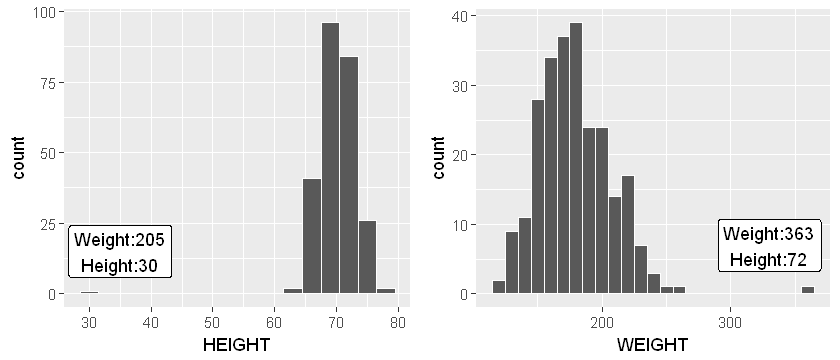

In [74]:
options(repr.plot.width=7, repr.plot.height=3);
multiplot(pHeight,pWeight,layout=matrix(data=c(1,2),nrow=1,byrow = T))

The 42nd observation in the **Height** histogram is only 29.5 inches tall(75cm), which is way shorter than normal people. However, the **Weight** and **Adiposity** values are normal, which indicates the value **Height** may be a typo. In this case, we have strong evidence to delete it.
The 39th observation in the **Weight** histogram is way heavier than other observations. In the sense of building a robust model for normal people, we do not consider the extreme example like this. Thus, we also remove the 39th record in further analysis.

We do not delete the rest potential outliers, since they do not show obvious abnormality and we try to keep as much information as possible.

# 3. Statistical Modeling

Based on prior knowledge of bodyfat, we think linear model is an appropriate model in this analysis. In order to achieve the goal of coming up with a simple, robust, and accurate “rule-of-thumb” method, we try to fit a multiple linear model. However, 14 variables seem to be too much in practice. We use different methods to do variable selection, and compare their performances.

Before modeling, we randomly choose 200 data as train set, and leave the rest as validation set. All the models are based on train set only, and tested on the validation set to check performance. 

Our goal is to find a model that is
* *simple*：no more than 5 variables
* *accurate*: predict well on the validation set
* *robust*: is not influenced too much by extreme values

## 3.1 Multiple Linear Regression

Based on other published work on this topic, a multiple linear model is likely to fit well:

$$ \text{(Body Fat %)}_i = \beta_0 + \beta_1x_1 + \dots + \beta_p x_p + \epsilon_i, \quad{} \epsilon_i \sim N(0,\sigma^2) $$

However, 14 variables are too many for a model to predict bodyfat, especially in this case. Some variables may not be useful, and may have high collinearity, which requires us to remove thr redundant ones. For example, in common sense, a person who is heavy also tends to have larger body circumferences. Therefore, we need to do variable selection.

### 3.1.1 Variable Selection

We tried stepwise model selection based on crteria like Mallow's Cp, AIC and BIC, and fit multiple linear models based on the variables selected. We compare each model's performance on validation set, and select one method that have the smallest mean squared error: $MSE = \frac{1}{N}\sum_{i=1}^{N}(y_i-\hat y_i)^2$

**Method**|Mallow's Cp|AIC|BIC
:-----:|:-----:|:-----:|:-----:
**MSE**|15.069|14.702|13.989


We find that when using the BIC method, the mean square error on validation set is the smallest. Variables *ABDOMEN*, *WRIST* and *WEIGHT* are selected, as shown below.
At this point, we come up with a multiple linear regression:

$$\text{BodyFat%}\text{ ~ }\text{Abdomen}+\text{Wrist}+\text{Weight}$$

### 3.1.2 MLR and interpret results

In [65]:
source("code/mlr.R");model.BIC.coeff
cat("MSE on the train set:", mlr.MSE.train)
cat("\nMSE on the validation set:", mlr.MSE.test)
cat("\nMultiple R squared:", Multiple.R.Squared)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-23.794,7.177,-3.315,0.001
WEIGHT,-0.073,0.025,-2.914,0.004
ABDOMEN,0.852,0.060,14.309,0.000
WRIST,-1.258,0.461,-2.728,0.007


MSE on the train set: 16.0271
MSE on the validation set: 13.9888
Multiple R squared: 0.7217

All coefficients are significant, which is not surprising. The result means:
* **Coefficients**: For example, keep other variables constant, if abdomen circumference increases by 1 cm, the body fat percentage will increase by 0.85%.
* **MSE**: Measures how well the prediction is. For example, the standard error of a prediction on the test data set can be estimated by $\sqrt{\text{MSE}} = 3.74$
* **Multiple R-squared**: Indicates that the variables explain about 72% of all the variation in BodyFat%

### 3.1.3 Model Diagnosis

Check Gauss-Markov assumptions: Gauss-Markov assumptions are met. Furthermore, no plausible highly influential points.

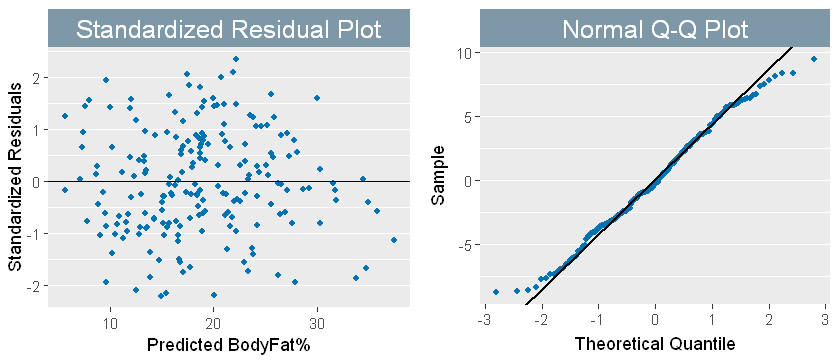

In [75]:
source("code/lasso.R");options(repr.plot.width=7, repr.plot.height=3)
multiplot(d1,d2,layout=matrix(data=c(1,2),nrow=1,byrow = T))

Check multi-colinearity: use *vif()* function to check multicollinearity between the variables selected. If the number is less than 10, we assume no significant multicollinearity among these variables.

In [52]:
t(mlr.vif)

WEIGHT,ABDOMEN,WRIST
5.67,4.488,1.989


## 3.2 LASSO

Lasso is another approach to select variables. The advantage of this method is that we can minimize the MSE on the validation set. 

The model is still: 
$$ \text{(Body Fat %)}_i = \beta_0 + \beta_1x_1 + \dots + \beta_p x_p$$

However, instead of minimizing $\sum_{i=1}^N (y_i-\beta_0-\beta_1x_i - \dots - \beta_px_p)^2$, which is what multiple linear regression does, Lasso minimizes:

$$\sum_{i=1}^N (y_i-\beta_0-\beta_1x_i - \dots - \beta_px_p)^2 +\lambda \left|\sum_{j=1}^p \beta_j \right| $$

We try different $\lambda^{(k)}$ to fit on the train set, then get coefficients $\beta^{(k)} = (\beta_0, \beta_1, \dots, \beta_{14})^{(k)}$. Then we get a predictive equation $y = X^\text{T}\beta^{(k)}$ to predict the BodyFat% on the validation set. The figure below shows the result of Lasso method.

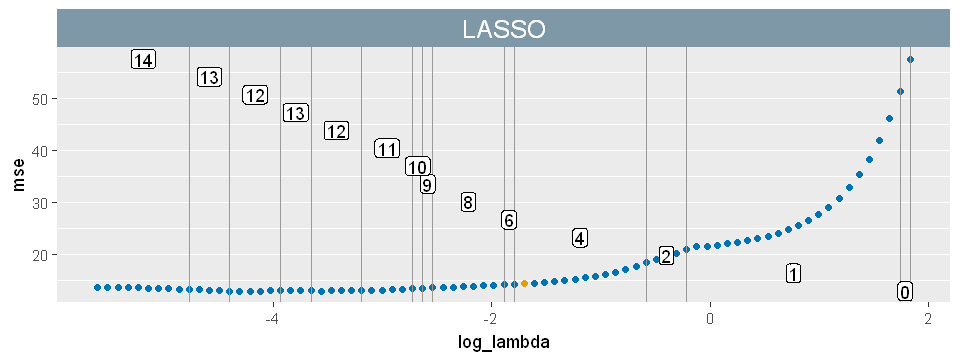

In [58]:
source("code/lasso.R");options(repr.plot.width=8, repr.plot.height=3);p

* The x-axis indicates $\log \lambda$, and y-axis indicates MSE. 
* The numbers 0,1,...,14 in the label indicates the number of variables selected in that case. As $\lambda$ increases, the number of variables selected decreases. 
* The grey verticle lines indicates where some variables are deleted.

Based on the result, we choose $\lambda$ to be 0.1824 (the highlighted point in the figure), because:
* It select only 4 variables. The model is *simple*.
* The MSE at this time is relatively small (around 15). The model is *accurate*.

In [59]:
lasso.result

(Intercept),AGE,HEIGHT,ABDOMEN,WRIST,lambda,MSE
-8.087,0.033,-0.186,0.662,-1.242,0.1824165,14.31907


## 4. Conclusion

Based on the two different methods discussed before, we can propose two linear models to predict body fat %:

$$
\begin{align} 
\text{(BodyFat %)} &= -23.794+0.852*\text{Abdomen}-1.258*\text{Wrist}-0.073*\text{Weight} \\
\text{(BodyFat %)} &= -8.087+0.662*\text{Abdomen}-1.242*\text{Wrist}-0.186*\text{Height}+0.033*\text{Age}
\end{align}
$$

The MSE for these two models are sepearately: 13.99, 14.32. Because the first model is simpler and more accurate, we prefer the first predictive equation.

**Possible rule of thumb**: "Your abdomen circumference (cm) multiply by 0.85 minus wrist circumference (cm) multiply by 1.26 minus weight (lbs) multiply by 0.07 minus 24"

**Example Usage**: For a normal graduate male student, with circumferences: Abdomen=85cm, Wrist=18cm, Weight=130lbs, his  predicted body fat percentage would be around 16.43%. A 95% probability that his body fat is between 8.26% and 24.59%.

**Strengths and weakness**:
- Our model selection is based on the prediction of validation set, which avoids overfitting.
- The final model is simple and easy to interpret.
- In our analysis, we divide the original data into train and validation set, which may lose some information when building the model.

### Each member's contribution
* **Shiwei Cao**: Lasso method; Summary writting
* **Shurong Gu**: Variable selection and final model building; Summary writting
* **Yuwei Sun**: Data preprocessing and presentation materials organizing; Making slides